# The Pedestrian Detection Pipeline
In this notebook the tools created previously are used to detect pedestrians in a given input image. 
Therfore the following steps must be performed:
1. Get the input picture
2. Use sliding window and image pyramids to extract regions of interest 
3. Classify regions of interest with resnet50 adapted for pedestrian detection
4. Apply non maximum surperssion to only dispaly best fitting bounding boxes




In [1]:
# imports
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from torchvision import datasets, transforms, models
import os
import time
import numpy as np
from pathlib import Path
from imutils.object_detection import non_max_suppression

#### Load resnet50 trained for pedestrian detection:

In [2]:
# get model from library
model = models.resnet50(pretrained=True)
# remove original output layer and replace it with 2 dimensinal layer 
number_input_features  = model.fc.in_features
num_classes =2
model.fc = nn.Linear(number_input_features, num_classes)
# load model trained in second notebook
model.load_state_dict(torch.load('./saved_models/pedestrianClassifier5Epochsiou045-2020-10-20-11-15-47.pt'))


<All keys matched successfully>

<class 'PIL.Image.Image'>


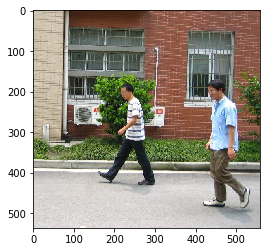

In [3]:
# get an image to test
from DataClass import PennFudanDataset
root = './data/PennFudanPed'
data = PennFudanDataset(root, transforms=None)

# display the selected image
sample_image = data[0]['img']
plt.imshow(sample_image)
print(type(sample_image))


In [36]:
from helpers import sliding_window, image_pyramid, display_bounding_box

def prediction_transforms(roi):
    
    pred_transform = transforms.Compose([        
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    roi = pred_transform(roi)
        
    return roi

def detect_pedestrian(image, model,slidingWindow_parameters={'height':int(275),'width':int(100),'step_w':50,'step_h':50},ImagePyramid_parameters=(224,224)):
       
    listOfBoundningBoxes = []
    listOfProbs =[]
    
    locs = []
    rois = []
    
    ImgWidth,imgHeight = image.size
    
    # initialize image pyramid
    imgPyramide = image_pyramid(image,minSize=ImagePyramid_parameters)
    
    for img in imgPyramide:
        
        # get current scale to rescale roi later 
        scale = ImgWidth/float(img.size[0])
        
        # create sliding window generator 
        sliding = sliding_window(img,
                                 window_size=(slidingWindow_parameters['width'],slidingWindow_parameters['height']),
                                 step_w=int(slidingWindow_parameters['step_w']/scale),
                                 step_h=int(slidingWindow_parameters['step_h']/scale))  
        
        
        # initialize sliding window
        for slide_img in sliding:
            
            windowBox = slide_img[0]
            windowBox= tuple(int(x*scale) for x in windowBox)
            
            locs.append(windowBox)
       
            
            # prepare region of interest for input into the classifier
            roi =slide_img[1].resize((224,int(224*2.5)))
            roi = prediction_transforms(roi)
            rois.append(roi)    
    
    
    # create timer to track time for this ....
    
    
    # classify the roi
    model.eval()
    with torch.no_grad():
        rois =torch.stack(rois, dim=0)
        
         
        
        predLoader = torch.utils.data.DataLoader(rois,batch_size=8)
        sm = torch.nn.Softmax(dim=1)
        outputs = []
        
        # split rois to prevent memory overload
        for inputs in predLoader:
            # use model to classify rois
            outputs.append(model(inputs))
        outputs =torch.cat(outputs, dim=0)
        
        _, preds = torch.max(outputs.data, 1)
        probs= sm(outputs)
        
        
        # get list of indexes that conatain a pedestrian
        indexes = preds.numpy().nonzero()
       
        for index in indexes[0]:
            print(f"Detected pedestrian at index {index}." )
            
            #imgToSave = display_bounding_box(img,[locs[index]],display=False)
            #plt.imsave(f"./data/detections/slidingNumber{index}.jpg",imgToSave)

            # scale windowBox
            #print(f'windowBox {windowBox}')
            #windowBox =[int(x*(1.5**pyramidStage)) for x in windowBox]
            #print(f'windowBox nacher {windowBox}')
            listOfBoundningBoxes.append(locs[index])
            listOfProbs.append(probs[index][1])
    

        
    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[xmin, ymin, xmax, ymax] for (xmin, ymin, xmax, ymax) in listOfBoundningBoxes])
    picks = non_max_suppression(rects, probs=listOfProbs, overlapThresh=0.1)
        
    return picks
                    

In [25]:
%%time
boxes = detect_pedestrian(sample_image,model)

Detected pedestrian at index 2.
Detected pedestrian at index 10.
Detected pedestrian at index 11.
Detected pedestrian at index 17.
Detected pedestrian at index 18.
Detected pedestrian at index 19.
Detected pedestrian at index 24.
Detected pedestrian at index 25.
Detected pedestrian at index 26.
CPU times: user 14.3 s, sys: 3.27 s, total: 17.6 s
Wall time: 10.4 s


In [26]:
boxes

array([[100, 100, 200, 375]])

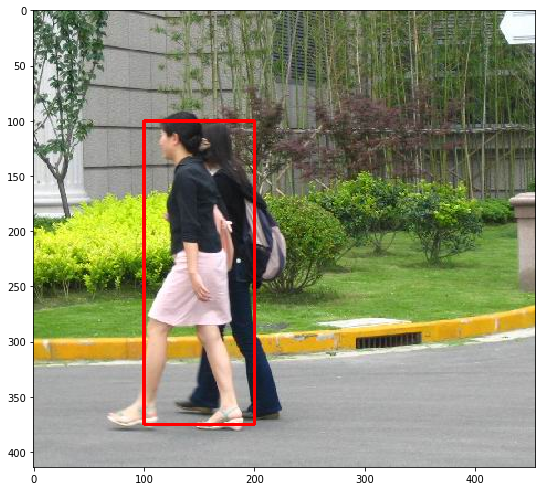

In [27]:
display_bounding_box(sample_image,boxes)

In [28]:
len(boxes)

1

In [29]:
sample_image = data[10]['img']

In [30]:
boxes = detect_pedestrian(sample_image,model)

Detected pedestrian at index 2.
Detected pedestrian at index 10.
Detected pedestrian at index 11.
Detected pedestrian at index 17.
Detected pedestrian at index 18.
Detected pedestrian at index 19.
Detected pedestrian at index 24.
Detected pedestrian at index 25.
Detected pedestrian at index 26.


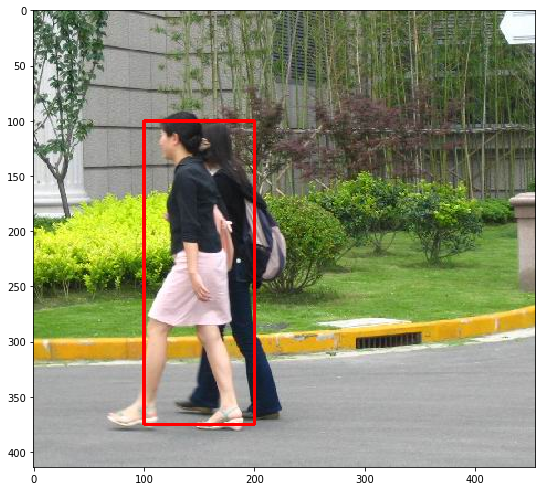

In [31]:
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 22.
Detected pedestrian at index 23.
Detected pedestrian at index 30.
Detected pedestrian at index 31.
Detected pedestrian at index 37.
Detected pedestrian at index 38.


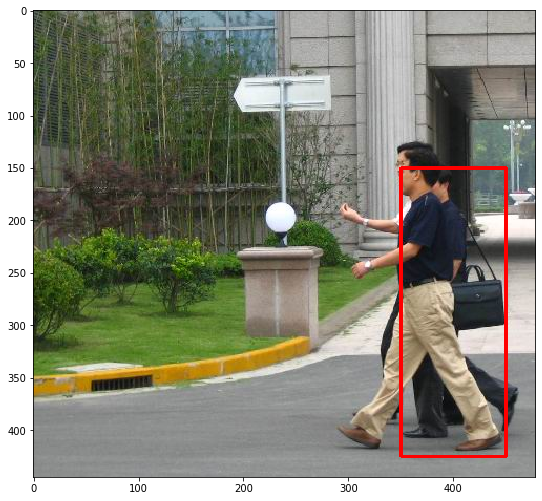

In [32]:
sample_image = data[2]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 0.
Detected pedestrian at index 3.
Detected pedestrian at index 4.
Detected pedestrian at index 5.
Detected pedestrian at index 9.
Detected pedestrian at index 10.
Detected pedestrian at index 11.
Detected pedestrian at index 15.
Detected pedestrian at index 16.


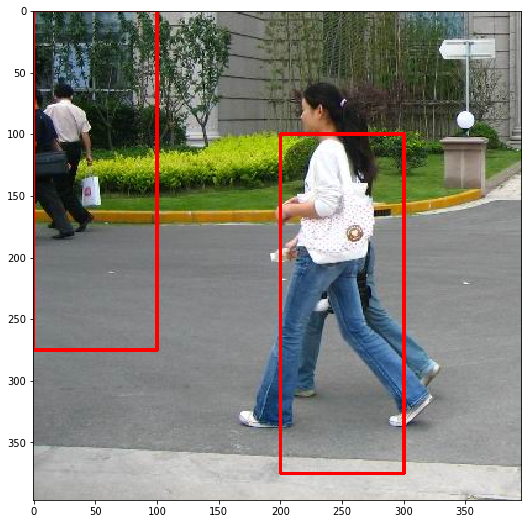

In [33]:
sample_image = data[3]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 3.
Detected pedestrian at index 4.
Detected pedestrian at index 8.
Detected pedestrian at index 9.


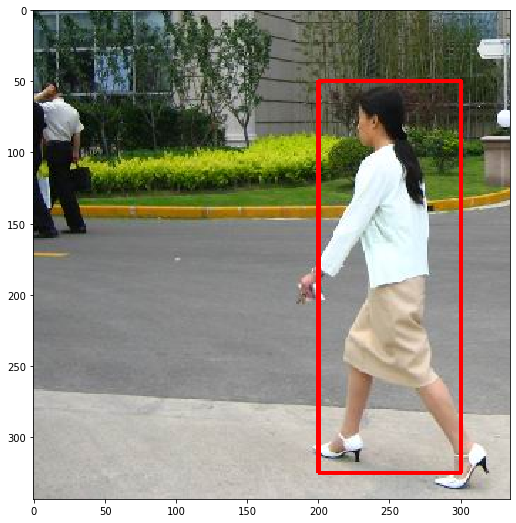

In [34]:
sample_image = data[4]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)

Detected pedestrian at index 17.
Detected pedestrian at index 21.
Detected pedestrian at index 26.
Detected pedestrian at index 27.
Detected pedestrian at index 30.
Detected pedestrian at index 31.
Detected pedestrian at index 36.
Detected pedestrian at index 37.
Detected pedestrian at index 38.
Detected pedestrian at index 40.
Detected pedestrian at index 46.
Detected pedestrian at index 47.
Detected pedestrian at index 56.
Detected pedestrian at index 65.
Detected pedestrian at index 66.


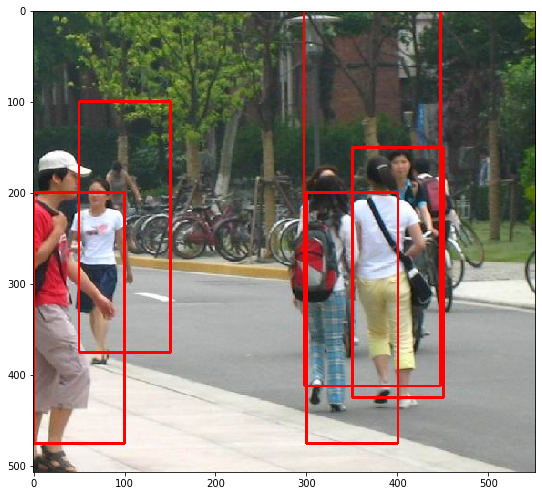

In [37]:
sample_image = data[40]['img']
boxes = detect_pedestrian(sample_image,model)
display_bounding_box(sample_image,boxes)